# # Final Project — Investment Research Multi-Agent System
# **Members**
# - Member 1 : Richa Arun Kumar Jha  
# - Member 2 : Raminder Singh  
# - Member 3 : Samiksha Kodgire
#
# **Notebook purpose**
# This notebook runs a multi-agent investment research pipeline (data, technical indicators,
# risk metrics, news sentiment, evaluation, optimization, and LLM-backed summaries), produces
# individual and combined visualizations, and writes a professional client-facing report.
#
# **Tickers analyzed:** AAPL, TSLA, GOOG, NVDA, INTC, MSFT
#
# The notebook auto-detects compute (GPU: T4 recommended) and chooses an LLM based on available VRAM.
# The final notebook file will be saved with the prefix `FinalProject_`.
# ---


In [1]:
# Install dependencies (Colab-friendly). If already installed, this will be fast.
!pip install -q yfinance pandas numpy nltk transformers accelerate torch sentencepiece requests psutil matplotlib tqdm textblob


In [2]:
# Imports & initial setup
import os, gc, json, time, math, re
from datetime import datetime, timezone
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, psutil
from transformers import pipeline
from tqdm.auto import tqdm
import nltk
from textblob import TextBlob

# NLTK data
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Styling for export-friendly figures
plt.style.use("seaborn-v0_8-muted")

# Output notebook filename
NOTEBOOK_FILENAME = "FinalProject_Investment_Research_Report.ipynb"
REPORT_CSV = "FinalProject_investment_final_report.csv"
RAW_JSON = "FinalProject_investment_all_results.json"


# ## Config & credentials
# Provide HuggingFace token and a News API key in Colab runtime variables for smooth runs. If not set, the notebook will prompt.


In [3]:
def safe_get_env(varname, prompt_text):
    val = os.getenv(varname)
    if val and len(val) > 8:
        return val
    try:
        from google.colab import userdata
        val = userdata.get(varname)
        if val:
            os.environ[varname] = val
            return val
    except Exception:
        pass
    try:
        val = input(f"🔑 Enter your {prompt_text}: ").strip()
    except Exception:
        val = ""
    os.environ[varname] = val
    return val

HF_TOKEN = safe_get_env("HUGGINGFACEHUB_API_TOKEN", "Hugging Face token")
NEWS_API_KEY = safe_get_env("NEWS_API_KEY", "News API key")
if HF_TOKEN:
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN

print("HuggingFace token loaded:", "YES" if HF_TOKEN else "NO")
print("News API key loaded:", "YES" if NEWS_API_KEY else "NO")


HuggingFace token loaded: YES
News API key loaded: YES


# ## Device detection & LLM selection (VRAM-aware)
# - Uses FP16 on GPU (if available), FP32 on CPU.
# - Chooses LLM by VRAM. The chosen model will be printed and included in the final report.


In [4]:
if torch.cuda.is_available():
    device_id = 0
    device = torch.device("cuda")
    props = torch.cuda.get_device_properties(device_id)
    total_vram_gb = props.total_memory / 1e9
    use_fp16 = True
    print(f"✅ GPU detected: {torch.cuda.get_device_name(device_id)} — VRAM: {total_vram_gb:.1f} GB (using FP16)")
else:
    device_id = -1
    device = torch.device("cpu")
    total_vram_gb = psutil.virtual_memory().available / 1e9 * 0.7
    total_vram_gb = min(total_vram_gb, 8)
    use_fp16 = False
    print(f"⚠️ CPU detected — usable RAM est: {total_vram_gb:.1f} GB (using FP32)")

print("Torch cuda device count:", torch.cuda.device_count())

def pick_llm_model(mem_gb):
    if mem_gb > 28:
        return "mistralai/Mistral-7B-Instruct-v0.3"
    elif mem_gb > 12:
        return "microsoft/phi-2"
    else:
        return "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

LLM_MODEL = pick_llm_model(total_vram_gb)
print("Selected LLM based on device memory:", LLM_MODEL)


✅ GPU detected: Tesla T4 — VRAM: 15.8 GB (using FP16)
Torch cuda device count: 1
Selected LLM based on device memory: microsoft/phi-2


# ## Agents — roles & definitions
# - **FinancialsAgent**: fetches company info and 1-year price series (plots close).  
# - **NewsAgent**: fetches headlines (Google News RSS) and computes sentiment (TextBlob).  
# - **TechnicalAgent**: computes SMA20, SMA50, EMA20, RSI14 and plots overlays.  
# - **RiskAgent**: computes volatility, max drawdown, VaR and rolling vol chart.  
# - **PortfolioAgent**: heuristic allocation suggestion.  
# - **EvaluatorAgent**: rule-based aggregator returning score & conclusion.  
# - **OptimizerAgent**: adjusts allocation based on evaluator.  
# - **InvestmentResearchAgent**: orchestrates pipeline and calls LLM summarizer.


In [5]:
# --- Agents implementations (merged & polished)
class BaseAgent:
    def log(self, msg): print(f"[{self.__class__.__name__}] {msg}")

class FinancialsAgent(BaseAgent):
    def act(self, ticker: str):
        t_obj = yf.Ticker(ticker)
        info = {}
        try:
            info = t_obj.info if hasattr(t_obj, "info") else {}
        except Exception:
            info = {}
        data = yf.download(ticker, period="1y", auto_adjust=True, progress=False)
        if data.empty:
            self.log(f"Warning: No price data for {ticker}")
            return {"type":"financials","latest_price":None,"marketCap":info.get("marketCap")}
        # Plot close price
        plt.figure(figsize=(10,3))
        plt.plot(data.index, data['Close'], label='Close')
        plt.title(f"{ticker} — Close Price (1y)")
        plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend()
        plt.show()
        return {"type":"financials",
                "latest_price": float(data['Close'].iloc[-1]),
                "marketCap": info.get("marketCap"),
                "trailingPE": info.get("trailingPE"),
                "forwardPE": info.get("forwardPE"),
                "dividendYield": info.get("dividendYield"),
                "beta": info.get("beta"),
                "price_df": data}

class NewsAgent(BaseAgent):
    def act(self, ticker: str):
        url = f"https://news.google.com/rss/search?q={ticker}+stock"
        titles=[]
        try:
            resp = requests.get(url, timeout=10)
            titles = re.findall(r"<title>(.*?)</title>", resp.text)
        except Exception as e:
            self.log(f"News fetch error: {e}")
        processed=[]
        for t in titles[2:7]:
            sent = TextBlob(t).sentiment.polarity
            cat = "earnings" if "earn" in t.lower() else "other"
            processed.append({"headline":t, "sentiment": round(sent,4), "category": cat})
        return {"type":"news", "data": processed}

class TechnicalAgent(BaseAgent):
    def rsi(self, series: pd.Series, period:int=14) -> pd.Series:
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -1*delta.clip(upper=0)
        ma_up = up.ewm(com=period-1, adjust=False).mean()
        ma_down = down.ewm(com=period-1, adjust=False).mean()
        rs = ma_up / ma_down
        return 100 - (100/(1+rs))
    def act(self, price_df: pd.DataFrame):
        if price_df is None or price_df.empty:
            return {"type":"technical","indicators":{}}
        df = price_df.copy()
        df['SMA20'] = df['Close'].rolling(20).mean()
        df['SMA50'] = df['Close'].rolling(50).mean()
        df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['RSI14'] = self.rsi(df['Close'],14)
        last = df.iloc[-1].to_dict()
        indicators = {"SMA20": last.get('SMA20'), "SMA50": last.get('SMA50'),
                      "EMA20": last.get('EMA20'), "RSI14": last.get('RSI14'),
                      "close": last.get('Close')}
        # Plot with color-coded SMA overlays
        plt.figure(figsize=(10,3))
        plt.plot(df.index, df['Close'], label='Close', linewidth=1.2)
        plt.plot(df.index, df['SMA20'], label='SMA20', color='#1f77b4')
        plt.plot(df.index, df['SMA50'], label='SMA50', color='#ff7f0e')
        plt.title("Price with SMA20 & SMA50"); plt.legend(); plt.grid(True); plt.show()
        return {"type":"technical","indicators":indicators,"df":df}

class RiskAgent(BaseAgent):
    def act(self, price_df: pd.DataFrame):
        if price_df is None or price_df.empty:
            return {"type":"risk","metrics":{}}
        df = price_df.copy()
        df['ret'] = df['Close'].pct_change().fillna(0)
        vol_annual = df['ret'].std() * np.sqrt(252)
        cum = (1+df['ret']).cumprod()
        running_max = cum.cummax()
        drawdown = (cum - running_max) / running_max
        max_dd = drawdown.min()
        var95 = df['ret'].quantile(0.05)
        metrics = {"vol_annual": float(vol_annual), "max_drawdown": float(max_dd), "var95": float(var95)}
        df['vol30'] = df['ret'].rolling(30).std() * np.sqrt(252)
        plt.figure(figsize=(10,2.5))
        plt.plot(df.index, df['vol30'], color='#2ca02c')
        plt.title("30-day Rolling Volatility (annualized)"); plt.grid(True); plt.show()
        return {"type":"risk","metrics":metrics,"df":df}

class PortfolioAgent(BaseAgent):
    def act(self, ticker, technical, risk, latest_price, capital=100000.0):
        if latest_price is None:
            return {"type":"portfolio","recommendation":"no_data"}
        sma20 = technical.get('SMA20'); sma50 = technical.get('SMA50'); rsi = technical.get('RSI14')
        vol = risk.get('vol_annual',0)
        alloc_pct = 0.02
        if sma20 and sma50 and sma20 > sma50 and (rsi is None or rsi < 70):
            alloc_pct = 0.05
        if vol and vol > 1.0:
            alloc_pct = max(0.005, alloc_pct * 0.5)
        notional = capital * alloc_pct
        shares = int(notional / latest_price) if latest_price and latest_price>0 else 0
        rec = {"allocation_pct": round(alloc_pct*100,3), "notional": round(notional,2), "shares": shares, "price": latest_price,
               "rationale": f"Trend {'up' if sma20 and sma50 and sma20>sma50 else 'neutral/down'}, vol {vol:.3f}"}
        return {"type":"portfolio","recommendation":rec}

class EvaluatorAgent(BaseAgent):
    def evaluate(self, news_data, technical, risk, financials):
        notes=[]; score=50
        news_sentiments = [n['sentiment'] for n in (news_data or [])]
        avg_news = np.mean(news_sentiments) if news_sentiments else 0.0
        if avg_news > 0.05: score += 20; notes.append("News sentiment positive")
        elif avg_news < -0.05: score -= 15; notes.append("News sentiment negative")
        else: notes.append("News sentiment neutral")
        sma20=technical.get('SMA20'); sma50=technical.get('SMA50'); rsi=technical.get('RSI14')
        if sma20 and sma50 and sma20 > sma50:
            score += 10; notes.append("Short-term trend above medium-term (SMA20 > SMA50)")
        else:
            notes.append("No confirmed short-term uptrend")
        if rsi is not None:
            if rsi > 70: score -= 10; notes.append(f"RSI high ({rsi:.1f}) - possible overbought")
            elif rsi < 30: score += 5; notes.append(f"RSI low ({rsi:.1f}) - possible oversold")
        vol = risk.get('vol_annual',0); max_dd = risk.get('max_drawdown',0)
        if vol > 0.6: score -= 10; notes.append(f"High volatility ({vol:.2f})")
        if max_dd and abs(max_dd) > 0.5: score -= 15; notes.append(f"Large drawdown ({max_dd:.2f})")
        fpe = financials.get('forwardPE')
        if fpe is not None:
            if fpe < 20: score +=5; notes.append("Forward PE attractive")
            elif fpe > 50: score -=5; notes.append("Forward PE elevated")
        score = max(0, min(100, int(score)))
        conclusion = "Positive" if score >= 65 else ("Neutral" if score >= 40 else "Negative")
        return {"score": score, "conclusion": conclusion, "notes": notes, "avg_news": float(avg_news)}

class OptimizerAgent(BaseAgent):
    def act(self, portfolio_rec, evaluator_feedback):
        rec = portfolio_rec.copy() if isinstance(portfolio_rec, dict) else {}
        score = evaluator_feedback.get('score',50)
        alloc_pct = rec.get('allocation_pct',0) if rec else 0
        if score < 40:
            new_alloc_pct = max(0.0, alloc_pct * 0.3)
            reason = "Reduce: weak outlook"
        elif score < 60:
            new_alloc_pct = max(0.0, alloc_pct * 0.7)
            reason = "Trim: neutral outlook"
        else:
            new_alloc_pct = alloc_pct
            reason = "Keep allocation"
        notional = new_alloc_pct/100 * 100000.0
        shares = int(notional / rec.get('price',1)) if rec else 0
        optimized = {"old_allocation_pct": alloc_pct, "new_allocation_pct": round(new_alloc_pct,4),
                     "new_notional": round(notional,2), "new_shares": shares, "reason": reason, "evaluator_notes": evaluator_feedback.get('notes',[])}
        return {"type":"optimized_portfolio","optimized":optimized}


# ## LLM summarizer (paragraph-form) — GPU-aware & safe fallback
# The LLM model is selected based on device memory (`LLM_MODEL`). On GPU this uses FP16 where possible. If an error occurs, the draft text is returned as fallback.


In [6]:
def make_llm_pipeline(model_name, device_idx, use_fp16_flag):
    kwargs = {"model": model_name, "device": device_idx, "max_new_tokens": 350, "temperature": 0.45, "repetition_penalty": 1.05, "trust_remote_code": True}
    if use_fp16_flag and device_idx >= 0:
        kwargs["torch_dtype"] = torch.float16
    else:
        kwargs["torch_dtype"] = torch.float32
    return pipeline("text-generation", **kwargs)

def summarize_with_llm_paragraph(draft_text, decision, alloc, news_text, model_name=LLM_MODEL):
    prompt = f"""You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
{draft_text}

DECISION: {decision}

PORTFOLIO: {json.dumps(alloc)}

NEWS: {news_text}
"""
    try:
        gen = make_llm_pipeline(model_name, device_id, use_fp16)
        with tqdm(total=1, desc="LLM summary", leave=False) as pbar:
            out = gen(prompt, max_new_tokens=300, do_sample=True)
            pbar.update(1)
        text = out[0].get("generated_text", draft_text)
        del gen, out
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return text.strip()
    except Exception as e:
        print(f"⚠️ LLM summarization failed: {e} — returning draft.")
        try:
            del gen
        except Exception:
            pass
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        return draft_text


# ## InvestmentResearchAgent — orchestrator
# Runs the full pipeline and returns structured results and LLM summaries.


In [7]:
class InvestmentResearchAgent(BaseAgent):
    def __init__(self, news_api_key=None):
        self.fin_agent = FinancialsAgent()
        self.news_agent = NewsAgent()
        self.tech_agent = TechnicalAgent()
        self.risk_agent = RiskAgent()
        self.port_agent = PortfolioAgent()
        self.eval_agent = EvaluatorAgent()
        self.opt_agent = OptimizerAgent()
        self.memory = {}
        self.news_api_key = news_api_key

    def run_full(self, ticker):
        self.log(f"Running full analysis for {ticker}")
        res = {}
        fin = self.fin_agent.act(ticker)
        res["financials"] = fin
        price_df = fin.get("price_df")
        tech = self.tech_agent.act(price_df)
        res["technical"] = tech.get("indicators", {})
        res["tech_df"] = tech.get("df")
        risk = self.risk_agent.act(price_df)
        res["risk"] = risk.get("metrics", {})
        res["risk_df"] = risk.get("df")
        news = self.news_agent.act(ticker)
        res["news"] = news.get("data", [])
        evalr = self.eval_agent.evaluate(res["news"], res["technical"], res["risk"], fin)
        res["evaluation"] = evalr
        port = self.port_agent.act(ticker, res["technical"], res["risk"], fin.get("latest_price"))
        res["portfolio"] = port
        opt = self.opt_agent.act(port.get("recommendation", {}), evalr)
        res["optimized"] = opt
        # draft text for LLM
        draft_lines = [f"Investment Research for {ticker}", f"Latest price: {fin.get('latest_price')}", "Key financials:"]
        for k in ['marketCap','trailingPE','forwardPE','dividendYield','beta']:
            draft_lines.append(f"- {k}: {fin.get(k)}")
        draft_lines.append("Technical indicators:")
        for k,v in res["technical"].items():
            draft_lines.append(f"- {k}: {v}")
        draft_lines.append("Risk metrics:")
        for k,v in res["risk"].items():
            draft_lines.append(f"- {k}: {v}")
        draft_lines.append("Headlines:")
        for a in res["news"]:
            draft_lines.append(f"- [{a.get('category')}] {a.get('headline')} (sent={a.get('sentiment')})")
        draft_text = "\n".join(draft_lines)
        summary_para = summarize_with_llm_paragraph(draft_text, evalr.get("conclusion"), port, "\n".join([n.get('headline','') for n in res["news"]]))
        res["summary"] = summary_para
        # store memory
        self.memory[ticker] = {"timestamp": datetime.now(timezone.utc).isoformat(), "conclusion": evalr.get("conclusion"), "score": evalr.get("score")}
        return res


# ## Run pipeline for the 6 tickers (progress shown)
# Tickers: AAPL, TSLA, GOOG, NVDA, INTC, MSFT



Starting analyses...



Tickers:   0%|          | 0/6 [00:00<?, ?it/s]

[InvestmentResearchAgent] Running full analysis for AAPL


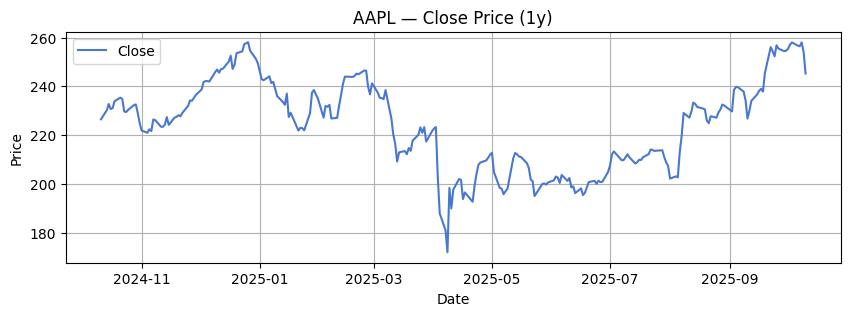

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


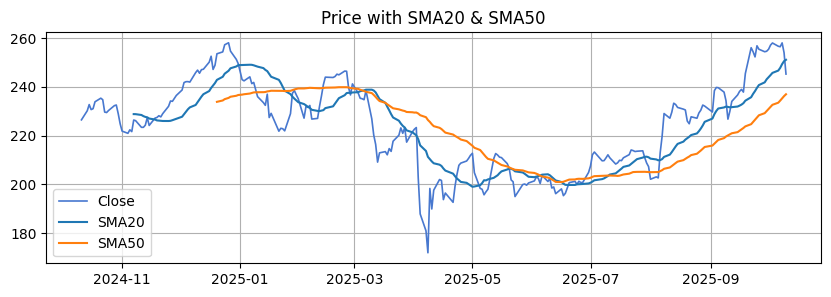

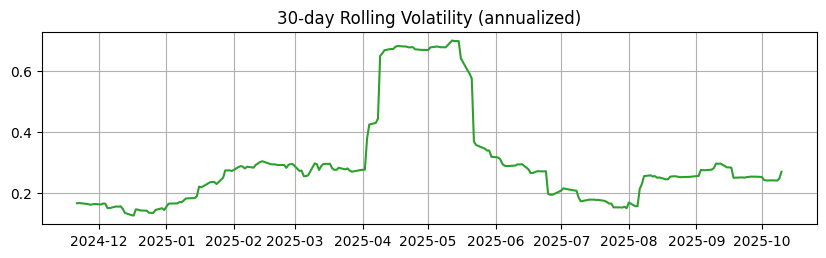

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[InvestmentResearchAgent] Running full analysis for TSLA


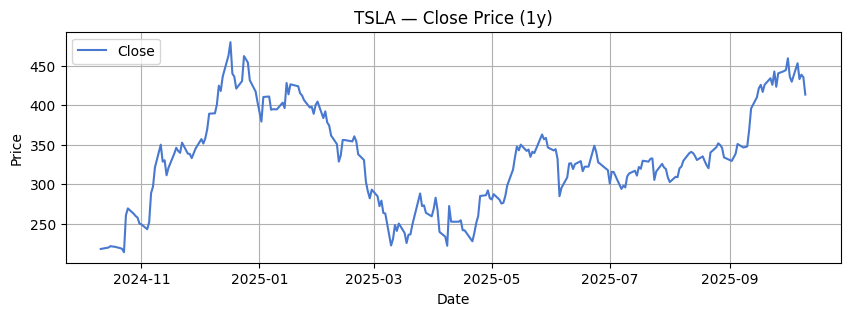

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


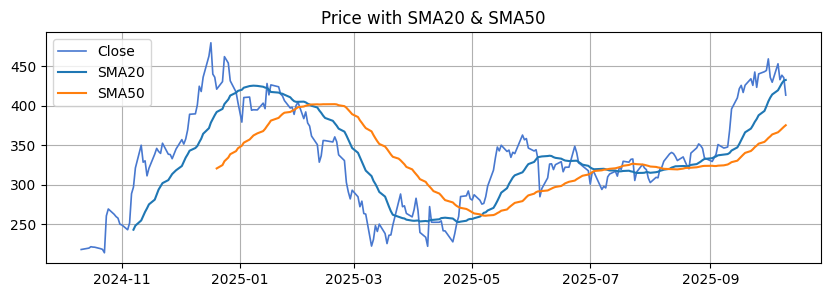

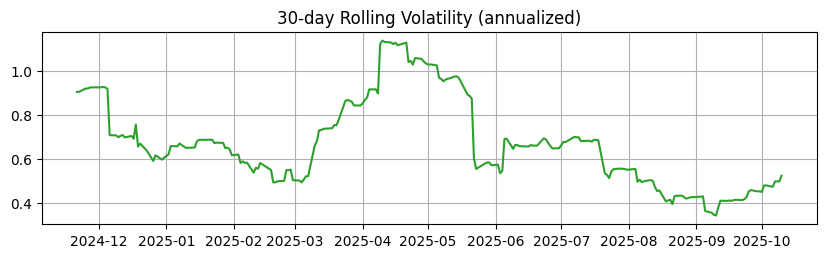

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[InvestmentResearchAgent] Running full analysis for GOOG


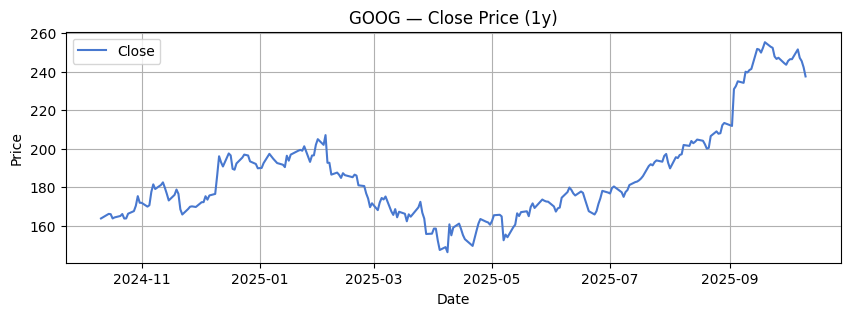

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


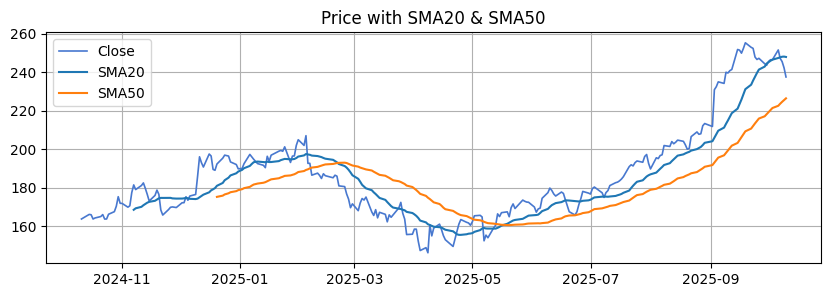

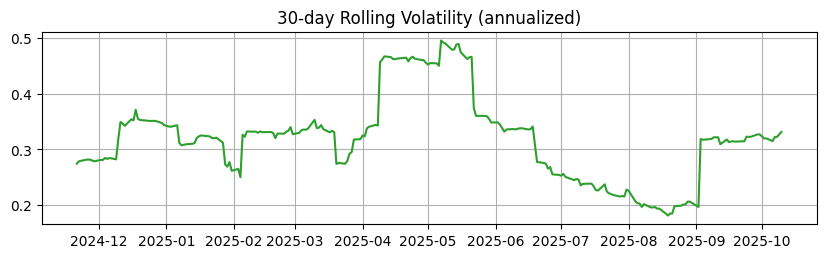

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[InvestmentResearchAgent] Running full analysis for NVDA


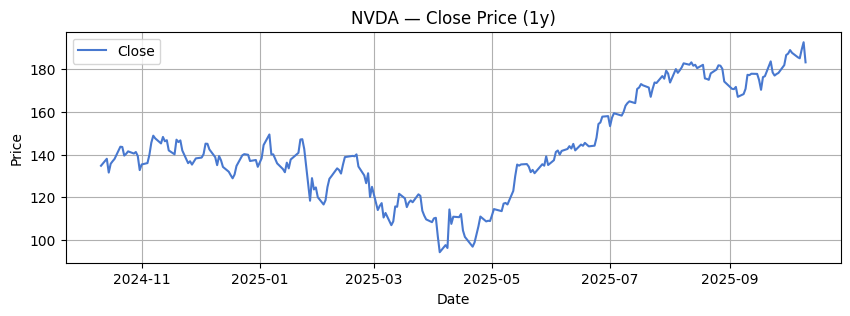

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


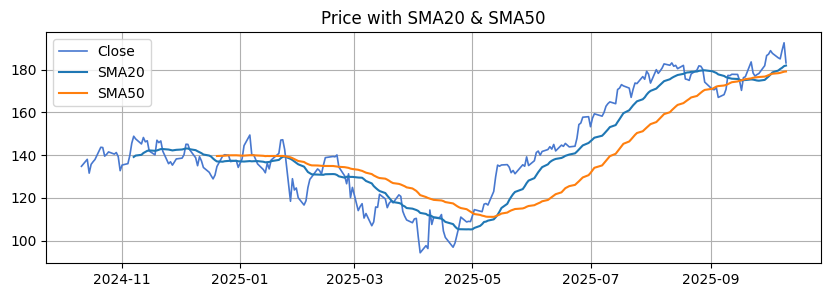

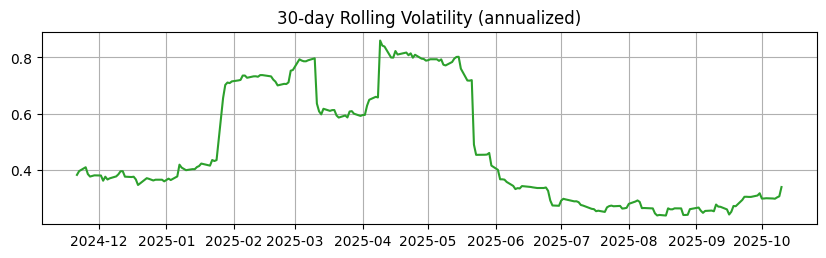

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[InvestmentResearchAgent] Running full analysis for INTC


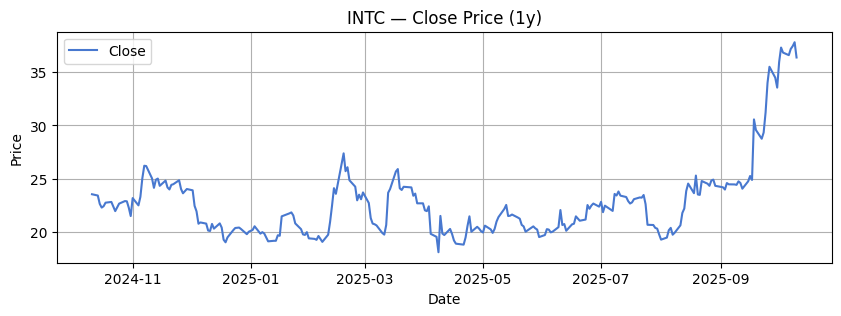

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


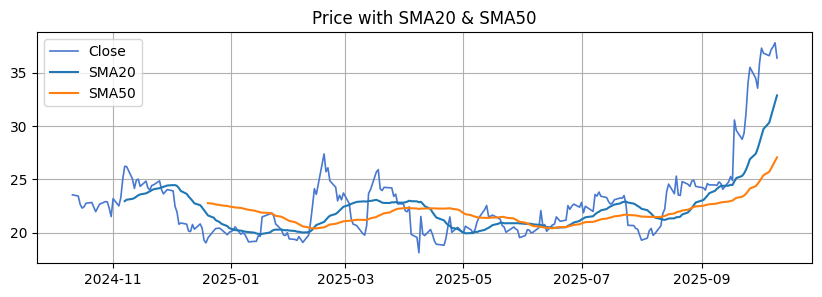

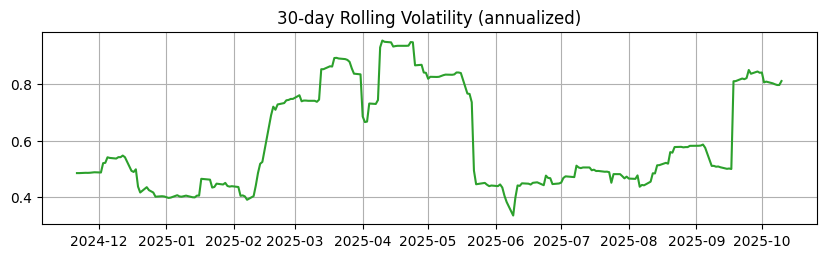

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[InvestmentResearchAgent] Running full analysis for MSFT


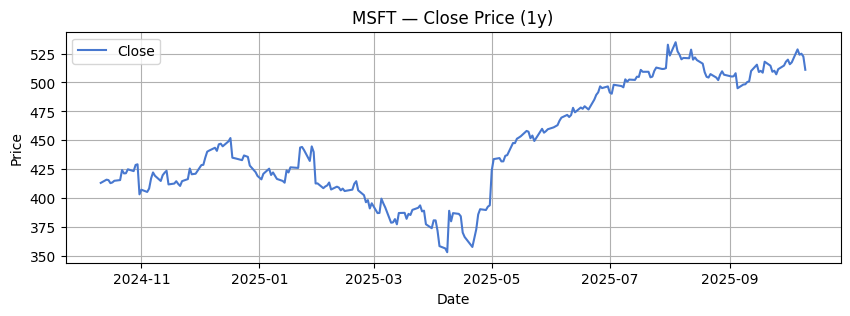

/tmp/ipython-input-1131731752.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "latest_price": float(data['Close'].iloc[-1]),


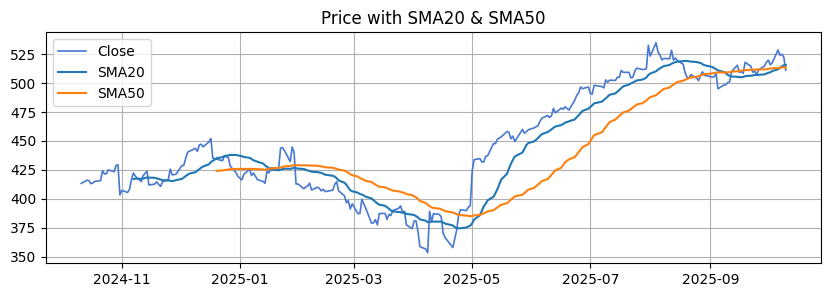

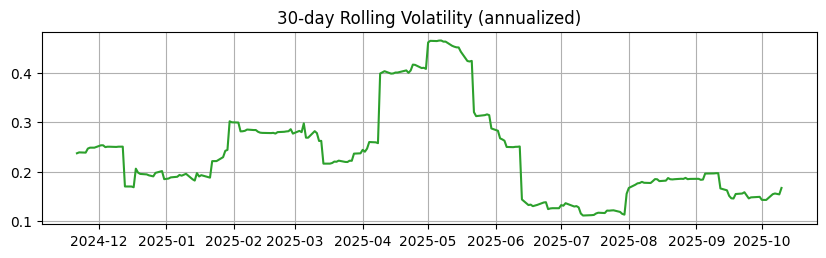

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM summary:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [8]:
tickers = ["AAPL","TSLA","GOOG","NVDA","INTC","MSFT"]
ira = InvestmentResearchAgent(news_api_key=NEWS_API_KEY)
all_results = {}

print("\nStarting analyses...\n")
for t in tqdm(tickers, desc="Tickers"):
    try:
        all_results[t] = ira.run_full(t)
    except Exception as e:
        print(f"[Main] Error analyzing {t}: {e}")
        all_results[t] = {"error": str(e)}
    finally:
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        time.sleep(0.25)


# ## Build a compact summary DataFrame for visualization and report tables


In [9]:
def build_summary_df(all_res):
    rows=[]
    for t,res in all_res.items():
        if 'error' in res:
            rows.append({"Ticker":t,"LatestPrice":None,"TechScore":None,"RSI":None,"RiskScore":None,"Sentiment":None,"Decision":"ERROR","EvalScore":None,"AllocPct":None})
            continue
        tech = res.get("technical",{})
        risk = res.get("risk",{})
        evalr = res.get("evaluation",{})
        port = res.get("portfolio",{}).get("recommendation",{})
        techscore = (tech.get("SMA20") - tech.get("SMA50")) if tech.get("SMA20") is not None and tech.get("SMA50") is not None else 0
        rsi = tech.get("RSI14")
        riskscore = (risk.get("vol_annual",0) + abs(risk.get("max_drawdown",0)))*50 if risk else 50
        sentiment = res.get("news",[])[0].get("sentiment") if res.get("news") else 50
        rows.append({
            "Ticker": t,
            "LatestPrice": res.get("financials",{}).get("latest_price"),
            "TechScore": techscore,
            "RSI": rsi,
            "RiskScore": riskscore,
            "Sentiment": sentiment,
            "Decision": evalr.get("conclusion"),
            "EvalScore": evalr.get("score"),
            "AllocPct": port.get("allocation_pct") if isinstance(port, dict) else None
        })
    return pd.DataFrame(rows)

summary_df = build_summary_df(all_results)
display(summary_df.style.background_gradient(subset=["TechScore","RiskScore","Sentiment"], cmap="coolwarm"))


,Ticker,LatestPrice,TechScore,RSI,RiskScore,Sentiment,Decision,EvalScore,AllocPct
0,AAPL,245.270004,0,None,32.921535,0.000000,Positive,70,2.000000
1,TSLA,413.489990,0,None,62.267995,-0.750000,Negative,5,2.000000
2,GOOG,237.490005,0,None,30.589945,-0.155600,Negative,35,2.000000
3,NVDA,183.160004,0,None,43.225048,0.000000,Negative,35,2.000000
4,INTC,36.369999,0,None,48.430364,0.600000,Neutral,60,2.000000
5,MSFT,510.959991,0,None,23.295775,0.042900,Positive,70,2.000000


# ## Individual visualizations & client summaries
# For each ticker we show:
# - Price with SMA overlays (color-coded)
# - 30-day rolling volatility (green)
# - Professional paragraph-form client summary (LLM)
# - Evaluation & portfolio details (printed as JSON for clarity)




===== AAPL — Visuals & Summary =====



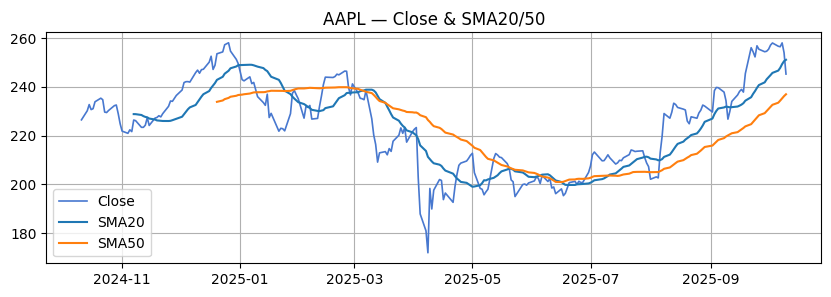

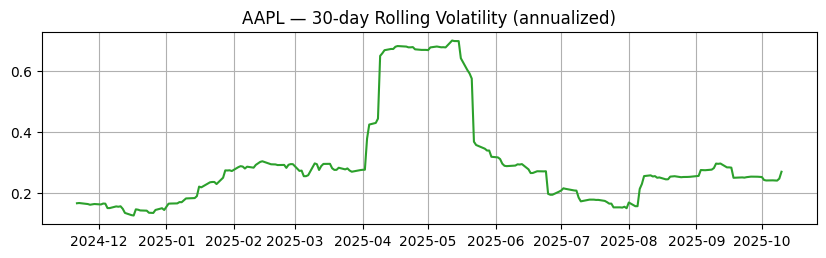


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for AAPL
Latest price: 245.27000427246094
Key financials:
- marketCap: 3639902470144
- trailingPE: 37.16212
- forwardPE: 29.515041
- dividendYield: 0.42
- beta: 1.094
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.3248254873818897
- max_drawdown: -0.3336052208070363
- var95: -0.032104851429163916
Headlines:
- [other] Apple (AAPL) Stock Might Be Rotting - AOL.com (sent=0.0)
- [other] Analyst Says Apple (AAPL) Is Going to Make a New All-Time High - Yahoo Finance (sent=0.1482)
- [other] Should You Buy Apple Stock Before Oct. 30? - The Motley Fool (sent=0.6)
- [other] Apple (NASDAQ

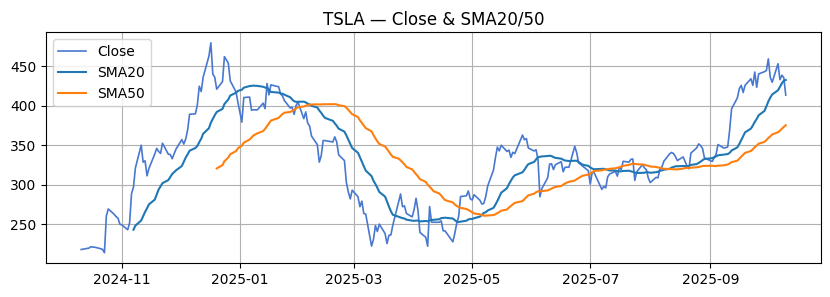

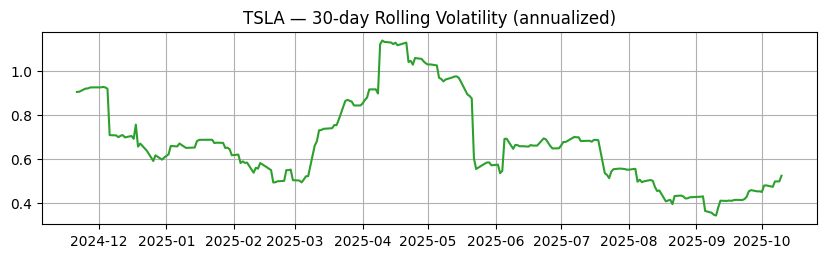


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for TSLA
Latest price: 413.489990234375
Key financials:
- marketCap: 1374916706304
- trailingPE: 243.2294
- forwardPE: 127.62037
- dividendYield: None
- beta: 2.086
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.7077031080423287
- max_drawdown: -0.5376568011858524
- var95: -0.056837875321660236
Headlines:
- [other] TSLA Stock: Daniel Ives Is ‘Disappointed’ by Tesla’s Lower Cost EVs - TipRanks (sent=-0.75)
- [other] Analyst Who Called Tesla (TSLA) a ‘Meme Stock’ Says Its Valuation is ‘Nonsensical’ - Yahoo Finance (sent=0.0)
- [other] Why I’m Dumping Tesla Stock (NASDAQ:TSLA) - S

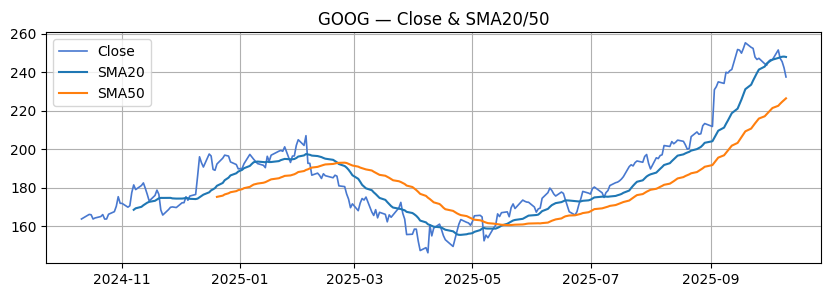

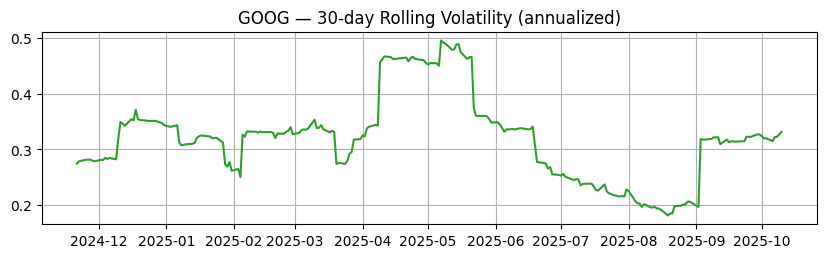


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for GOOG
Latest price: 237.49000549316406
Key financials:
- marketCap: 2866073305088
- trailingPE: 25.318764
- forwardPE: 26.535196
- dividendYield: 0.35
- beta: 1.0
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.31829830365005707
- max_drawdown: -0.2935006055551588
- var95: -0.02975463849184449
Headlines:
- [other] Alphabet (NASDAQ:GOOG) Stock Price Down 1.9% - Here's Why - MarketBeat (sent=-0.1556)
- [other] Google Launches Gemini Enterprise As Tech Giants Race To Offer AI Agents - Investor's Business Daily (sent=0.0)
- [other] Google's stock is up 70%: Can the rally last? - 

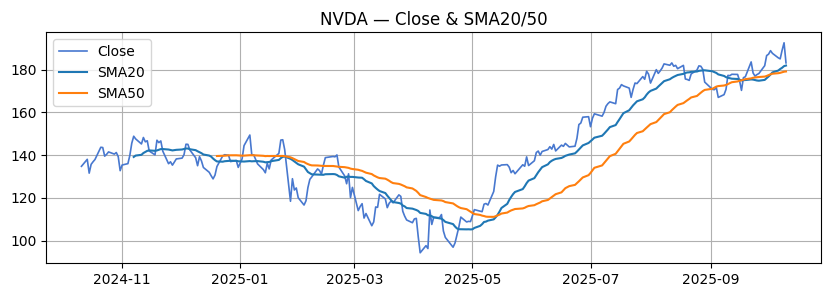

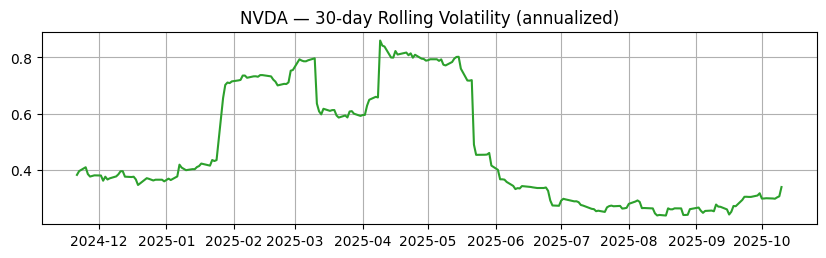


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for NVDA
Latest price: 183.16000366210938
Key financials:
- marketCap: 4459396595712
- trailingPE: 52.034092
- forwardPE: 44.456314
- dividendYield: 0.02
- beta: 2.123
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.49569069763223733
- max_drawdown: -0.3688102669914983
- var95: -0.04705952469839477
Headlines:
- [other] AMD &amp; Nvidia (NVDA) Stocks Fall on Senate AI Export Bill - TipRanks (sent=0.0)
- [other] Nvidia Stock Slides After Trump Suggests ‘Massive Increase’ of Tariffs on China - Barron's (sent=0.0)
- [other] Why Nvidia (NVDA) Stock Is Trading Lower Today - Yahoo Fina

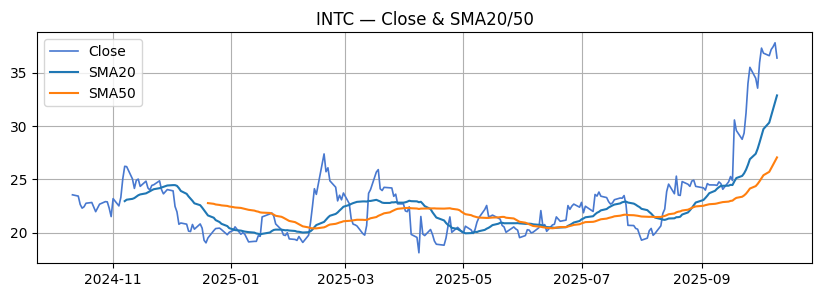

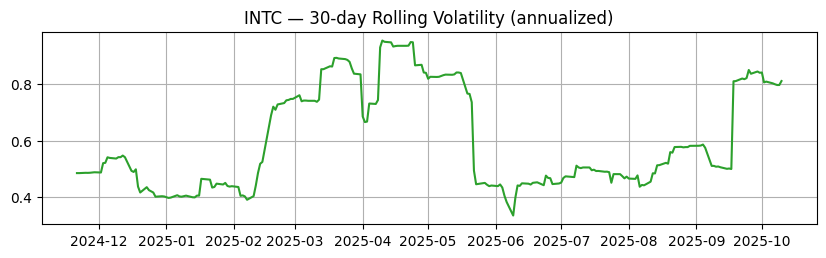


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for INTC
Latest price: 36.369998931884766
Key financials:
- marketCap: 173020004352
- trailingPE: None
- forwardPE: 37.494843
- dividendYield: None
- beta: 1.33
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.6305276798853632
- max_drawdown: -0.3380796069817177
- var95: -0.05278583669672623
Headlines:
- [other] Where Will Intel Stock Be in 1 Year? - The Motley Fool (sent=0.6)
- [other] Intel Stock Falls After Downgrade. Why This Analyst Is Worried After Nvidia, SoftBank Deals - Barron's (sent=0.0)
- [other] Intel (NASDAQ:INTC) Stock Price Expected to Rise, TD Cowen Analyst Says 

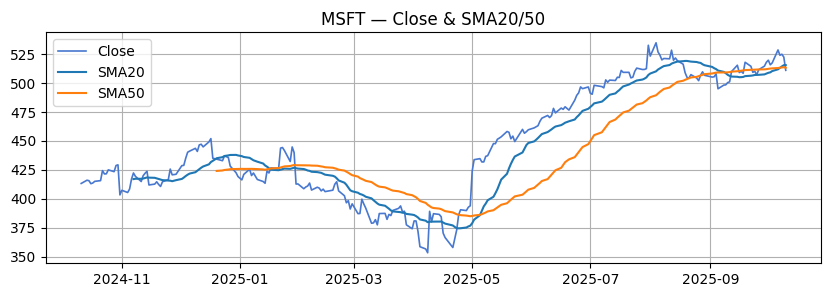

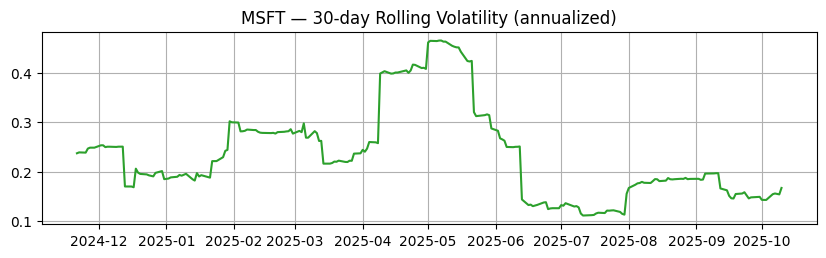


--- Professional client summary (LLM) ---

You are an experienced investment strategist. Write a concise, professional paragraph that a retail investor can understand. Integrate portfolio and news context where relevant. Keep language clear and avoid heavy jargon. Provide the main recommendation and rationale.

DRAFT:
Investment Research for MSFT
Latest price: 510.9599914550781
Key financials:
- marketCap: 3798050537472
- trailingPE: 37.460407
- forwardPE: 34.177925
- dividendYield: 0.71
- beta: 1.023
Technical indicators:
- SMA20: None
- SMA50: None
- EMA20: None
- RSI14: None
- close: None
Risk metrics:
- vol_annual: 0.24765858531911517
- max_drawdown: -0.21825690565450617
- var95: -0.021679437448987777
Headlines:
- [other] Jim Cramer About Microsoft (MSFT) Bull Comments: ‘He’s Been Dead Right’ - Yahoo Finance (sent=0.0429)
- [other] Tech megacaps lose $770 billion in value as Nasdaq suffers steepest drop since April - CNBC (sent=-0.6)
- [other] Microsoft: The AI Bubble's Best Risk/

In [10]:
def plot_price_with_sma(res, ticker):
    df = res.get("tech_df")
    if df is None or df.empty:
        print(f"No price DF for {ticker}")
        return
    plt.figure(figsize=(10,3))
    plt.plot(df.index, df['Close'], label='Close', linewidth=1.2)
    if 'SMA20' in df.columns: plt.plot(df.index, df['SMA20'], label='SMA20', color='#1f77b4')
    if 'SMA50' in df.columns: plt.plot(df.index, df['SMA50'], label='SMA50', color='#ff7f0e')
    plt.title(f"{ticker} — Close & SMA20/50"); plt.legend(); plt.grid(True); plt.show()

def plot_rolling_vol(res, ticker):
    df = res.get("risk_df")
    if df is None or df.empty or 'vol30' not in df.columns:
        print(f"No vol data for {ticker}")
        return
    plt.figure(figsize=(10,2.5))
    plt.plot(df.index, df['vol30'], color='#2ca02c')
    plt.title(f"{ticker} — 30-day Rolling Volatility (annualized)"); plt.grid(True); plt.show()

for t in tickers:
    print(f"\n\n===== {t} — Visuals & Summary =====\n")
    res = all_results.get(t, {})
    plot_price_with_sma(res, t)
    plot_rolling_vol(res, t)
    print("\n--- Professional client summary (LLM) ---\n")
    print(res.get("summary","(No summary available)"))
    print("\n--- Evaluation & Portfolio ---")
    print(json.dumps(res.get("evaluation",{}), indent=2))
    print(json.dumps(res.get("portfolio",{}), indent=2))


# ## Combined visualizations: radar & allocation charts
# - Radar: TechScore, RSI, Safety (100 - RiskScore), Sentiment (color-coded)  
# - Allocation: base allocation & optimized allocation (bar chart for Positive recommendations)


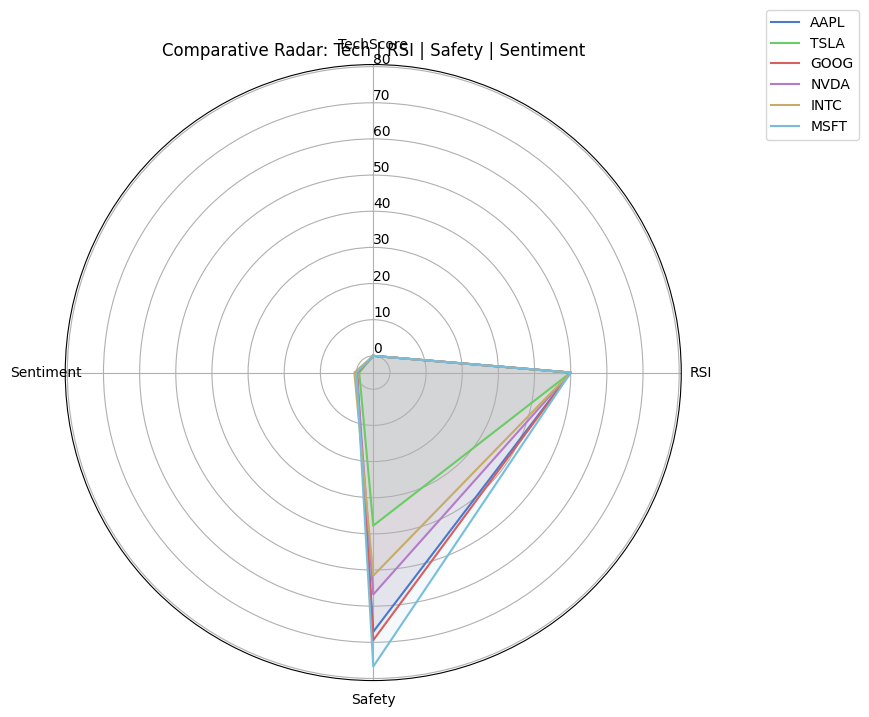


Allocation table (base vs optimized):


,Ticker,Decision,EvalScore,BaseAllocPct,OptimizedAllocPct
0,AAPL,Positive,70,2.00,2.00
1,TSLA,Negative,5,2.00,0.60
2,GOOG,Negative,35,2.00,0.60
3,NVDA,Negative,35,2.00,0.60
4,INTC,Neutral,60,2.00,2.00
5,MSFT,Positive,70,2.00,2.00


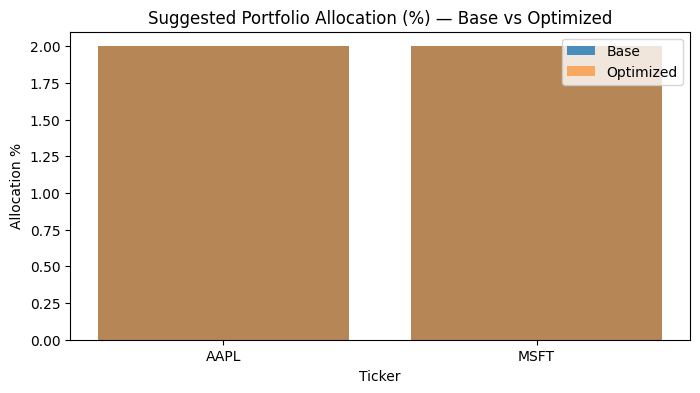

In [11]:
def plot_radar(df):
    if df.empty:
        print("No data for radar")
        return
    import numpy as np
    labels = ["TechScore","RSI","Safety","Sentiment"]
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    for _,row in df.iterrows():
        vals = [
            row.get("TechScore",0) if row.get("TechScore") is not None else 0,
            row.get("RSI",50) if row.get("RSI") is not None else 50,
            100 - (row.get("RiskScore",50) if row.get("RiskScore") is not None else 50),
            row.get("Sentiment",50) if row.get("Sentiment") is not None else 50
        ]
        vals += vals[:1]
        ax.plot(angles, vals, label=row.get("Ticker","N/A"))
        ax.fill(angles, vals, alpha=0.08)
    ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels)
    ax.set_rlabel_position(0)
    plt.title("Comparative Radar: Tech | RSI | Safety | Sentiment")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1)); plt.show()

def compute_alloc_table(all_res):
    rows=[]
    for t,res in all_res.items():
        port = res.get("portfolio",{}).get("recommendation",{}) if res.get("portfolio") else {}
        opt = res.get("optimized",{}).get("optimized",{})
        rows.append({
            "Ticker": t,
            "Decision": res.get("evaluation",{}).get("conclusion"),
            "EvalScore": res.get("evaluation",{}).get("score"),
            "BaseAllocPct": port.get("allocation_pct") if isinstance(port, dict) else None,
            "OptimizedAllocPct": opt.get("new_allocation_pct") if opt else None
        })
    return pd.DataFrame(rows)

plot_radar(summary_df)
alloc_table = compute_alloc_table(all_results)
print("\nAllocation table (base vs optimized):")
display(alloc_table.style.format({"BaseAllocPct":"{:.2f}", "OptimizedAllocPct":"{:.2f}"}))

# Bar chart for positive recommendations
buy_df = alloc_table[alloc_table["Decision"]=="Positive"]
if not buy_df.empty:
    plt.figure(figsize=(8,4))
    plt.bar(buy_df["Ticker"], buy_df["BaseAllocPct"].astype(float), color='#1f77b4', alpha=0.8, label='Base')
    plt.bar(buy_df["Ticker"], buy_df["OptimizedAllocPct"].astype(float), color='#ff7f0e', alpha=0.6, label='Optimized')
    plt.title("Suggested Portfolio Allocation (%) — Base vs Optimized")
    plt.xlabel("Ticker"); plt.ylabel("Allocation %"); plt.legend(); plt.show()
else:
    print("No Positive recommendations to show in allocation chart.")


# ## Risk index & volatility table
# Shows per-ticker volatility, max drawdown, var95 and risk index (normalized).


In [12]:
risk_rows=[]
for t,res in all_results.items():
    risk = res.get("risk",{})
    metrics = res.get("risk",{})
    if 'metrics' in res.get("risk",{}): metrics = res.get("risk",{}).get('metrics',{})
    # conservatively fetch known keys
    vol = metrics.get("vol_annual", None)
    max_dd = metrics.get("max_drawdown", None)
    var95 = metrics.get("var95", None)
    risk_index = None
    if vol is not None and max_dd is not None:
        risk_index = (vol + abs(max_dd)) * 50
    risk_rows.append({"Ticker":t, "VolAnnual": vol, "MaxDrawdown": max_dd, "VaR95": var95, "RiskIndex": risk_index})
risk_df = pd.DataFrame(risk_rows)
display(risk_df.style.background_gradient(subset=["RiskIndex"], cmap="Reds"))


,Ticker,VolAnnual,MaxDrawdown,VaR95,RiskIndex
0,AAPL,0.324825,-0.333605,-0.032105,32.921535
1,TSLA,0.707703,-0.537657,-0.056838,62.267995
2,GOOG,0.318298,-0.293501,-0.029755,30.589945
3,NVDA,0.495691,-0.368810,-0.047060,43.225048
4,INTC,0.630528,-0.338080,-0.052786,48.430364
5,MSFT,0.247659,-0.218257,-0.021679,23.295775


# ## Final readable report table & CSV
# - Each row contains ticker, evaluator decision, numeric score, allocation suggestion, and the LLM paragraph summary.
# - Saved as `FinalProject_investment_final_report.csv`.


In [13]:
def final_report_table(all_res):
    rows=[]
    for t,res in all_res.items():
        rows.append({
            "Ticker": t,
            "Decision": res.get("evaluation",{}).get("conclusion"),
            "EvalScore": res.get("evaluation",{}).get("score"),
            "BaseAllocPct": (res.get("portfolio",{}).get("recommendation",{}).get("allocation_pct") if isinstance(res.get("portfolio",{}).get("recommendation",{}), dict) else None),
            "OptimizedAllocPct": (res.get("optimized",{}).get("optimized",{}).get("new_allocation_pct") if res.get("optimized") else None),
            "Summary": res.get("summary","")
        })
    return pd.DataFrame(rows)

report_df = final_report_table(all_results)
display(report_df)
report_df.to_csv(REPORT_CSV, index=False)
print(f"\nSaved final report CSV: {REPORT_CSV}")


,Ticker,Decision,EvalScore,BaseAllocPct,OptimizedAllocPct,Summary
0,AAPL,Positive,70,2.0,2.0,You are an experienced investment strategist. ...
1,TSLA,Negative,5,2.0,0.6,You are an experienced investment strategist. ...
2,GOOG,Negative,35,2.0,0.6,You are an experienced investment strategist. ...
3,NVDA,Negative,35,2.0,0.6,You are an experienced investment strategist. ...
4,INTC,Neutral,60,2.0,2.0,You are an experienced investment strategist. ...
5,MSFT,Positive,70,2.0,2.0,You are an experienced investment strategist. ...



Saved final report CSV: FinalProject_investment_final_report.csv


# ## Safe JSON save (fix for DataFrame serialization)
# Writes `FinalProject_investment_all_results.json` — DataFrames replaced with placeholders.


In [14]:
import pandas as _pd
def safe_json(obj):
    if isinstance(obj, _pd.DataFrame):
        return "DATAFRAME"
    elif isinstance(obj, _pd.Series):
        return obj.to_list()
    elif isinstance(obj, dict):
        return {k: safe_json(v) for k,v in obj.items()}
    elif isinstance(obj, (list, tuple, set)):
        return [safe_json(v) for v in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        try:
            json.dumps(obj)
            return obj
        except Exception:
            return str(obj)

with open(RAW_JSON, "w") as f:
    json.dump(safe_json(all_results), f, indent=2)

print(f"Saved raw results to JSON (placeholders for DataFrames): {RAW_JSON}")


Saved raw results to JSON (placeholders for DataFrames): FinalProject_investment_all_results.json


# ## Appendix: Notes, LLM used & next steps
# - **LLM chosen:** The notebook auto-selected **{LLM_MODEL}** based on available VRAM (printed earlier).  
# - For faster summarization on the T4, consider using a quantized model (bitsandbytes + 4-bit)

# **Next steps (Futuristic):** quantization + bitsandbytes path
# ---
